In [5]:
## imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from sklearn.naive_bayes import CategoricalNB
import numpy as np

import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
import random
from PIL import Image
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [6]:
# Cell 1: Imports and dataset path
from pathlib import Path

# Adjust this path to wherever you unpacked the dataset
DATA_ROOT = Path('/home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2')

train_dir = DATA_ROOT / 'train'
valid_dir = DATA_ROOT / 'valid'
test_dir  = DATA_ROOT / 'test'

print("Train folder:", train_dir.resolve())
print("Valid folder:", valid_dir.resolve())
print("Test  folder:", test_dir.resolve())

Train folder: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train
Valid folder: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid
Test  folder: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test


In [7]:
# Cell 2: Build tf.data.Dataset objects
batch_size = 32
img_size   = (200, 200)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
)

class_names = train_ds.class_names
print(f"Found {len(class_names)} classes:", class_names)


Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 53 classes: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three

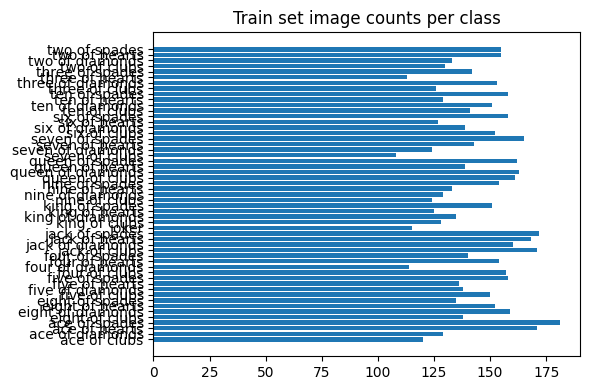

In [8]:
# Cell 3: Plot class distribution
import numpy as np
from collections import Counter

# walk dirs to count
counts = Counter()
for path in Path(train_dir).iterdir():
    if path.is_dir():
        counts[path.name] = len(list(path.glob('*.jpg')))

plt.figure(figsize=(6,4))
plt.barh(list(counts.keys()), list(counts.values()))
plt.title("Train set image counts per class")
plt.tight_layout()


2025-05-04 01:05:31.018465: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


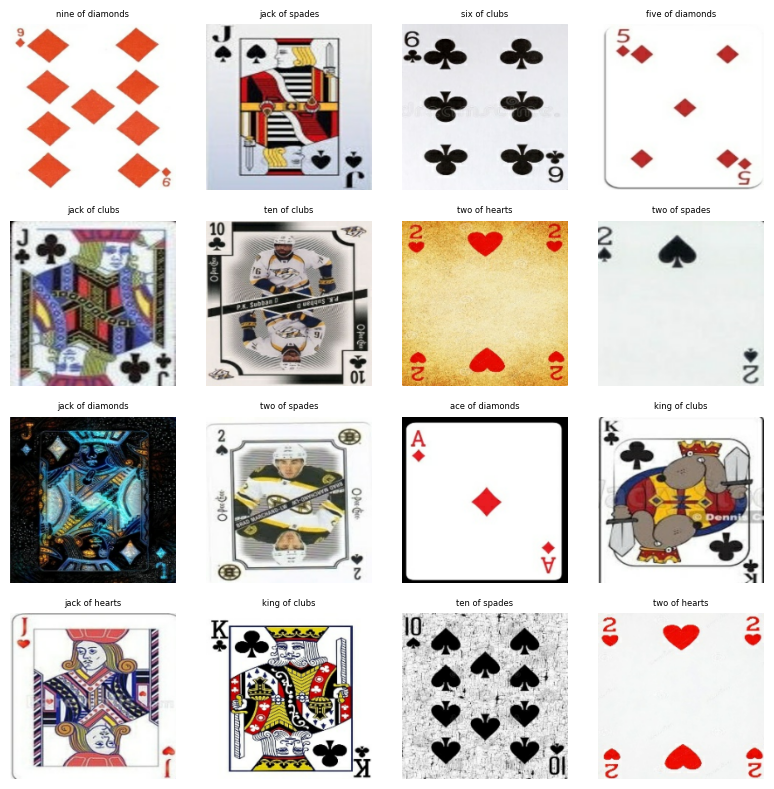

In [9]:
# Cell 4: Visualize a batch of images
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])], fontsize=6)
        plt.axis("off")
plt.tight_layout()


In [10]:
# Cell 5: Check for unreadable files
import os
from PIL import Image

bad = []
for root, _, files in os.walk(train_dir):
    for fname in files:
        path = os.path.join(root, fname)
        try:
            Image.open(path).verify()
        except Exception as e:
            bad.append(path)
print("Corrupted files:", bad if bad else "None 🎉")


Corrupted files: None 🎉
